# **Sutton Trust Music & Science Workshop**

Instructor: Huw Cheston, PhD researcher @ Centre for Music & Science, University of Cambridge

![ST](https://summerschools.suttontrust.com/wp-content/themes/sutton-trust-summer-programme/assets/img/summer_school_logo.png)

© Huw Cheston 2023, hwc31@cam.ac.uk

# Beat tracking using neural networks

![NN](https://www.unite.ai/wp-content/uploads/2023/05/Featured-Blog-Image-Liquid-Neural-Networks-Definition-Applications-and-Challenges.jpg)

Imagine if we could teach computers to understand and perceive the rhythm of our favorite songs, just like we do. That's where neural networks come into play. They're very good at recognizing patterns, and in doing so we can train them to spot the beats in music and audio tracks. This is called beat tracking: the process of finding the pulse of a song. By feeding loads of examples into these networks, they learn to identify the beats, helping us analyze and even create music in exciting new ways.

In this workbook, we'll going to use a neural network implemented in the [MadMom library](https://madmom.readthedocs.io/en/v0.16.1/index.html), a standard library used in music cognition research, to track the pulse of various songs. We'll rip the songs direct from YouTube, so you won't need to download anything beforehand. You also don't need to have any experience of programming to use this workbook, and all the various options will be explained as you go.





## Setup

**Before you do anything else**, hit the *Play* button below, next to the **Show code** line. You may need to move your mouse for this to appear. Please let me know if you get any errors when running this!

In [1]:
# @title
!pip install git+https://github.com/CPJKU/madmom.git yt-dlp

from madmom.features.downbeats import RNNDownBeatProcessor, DBNDownBeatTrackingProcessor
import numpy as np
import soundfile as sf
import warnings
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt

# @title
class BeatTracker:
  sample_rate = 44100
  tempo = None
  fps = 100
  duration = 60
  beats = None

  def __init__(self, **kwargs):
    self.passes = kwargs.get('passes', 3)
    self.starting_min = kwargs.get('starting_min_tempo', 100)
    self.starting_max = kwargs.get('starting_max_tempo', 400)
    self.starting_position = kwargs.get('starting_position', 1)
    self.threshold = kwargs.get('threshold', 0.12994145724543088)
    self.transition_lambda = kwargs.get('transition_lambda', 18.85352072454308)
    self.beats_per_bar = kwargs.get('beats_per_bar', 4)
    self.correct = kwargs.get('correct', True)
    self.tempo = None
    self.audio, _ = sf.read(
          'youtube.mp3',
          dtype='float64',
          start=self.starting_position * self.sample_rate,
          stop=(self.starting_position + self.duration) * self.sample_rate,
    )

  @staticmethod
  def iqr_filter(
        arr: np.array,
        low: int = 25,
        high: int = 75,
        mult: float = 1.5,
        fill_nans: bool = False,
  ) -> np.ndarray:
    """Simple IQR-based range filter that subsets array b where q1(b) - 1.5 * iqr(b) < b[n] < q3(b) + 1.5 * iqr(b)

    Parameters:
        arr (np.array): the array of values to clean
        low (int, optional): the lower quantile to use, defaults to 25
        high (int, optional): the upper quantile to use, defaults to 75
        mult (float, optional): the amount to multiply the IQR by, defaults to 1.5
        fill_nans (bool, optional): replace cleaned values with np.nan, such that the array shape remains the same

    Returns:
        np.array

    """
    # Get our upper and lower bound from the array
    min_ = np.nanpercentile(arr, low)
    max_ = np.nanpercentile(arr, high)
    # If the upper and lower bounds are equal, IQR will be 0.0, and our cleaned array will be empty. So don't clean.
    if min_ - max_ == 0:
        return arr
    # Construct the IQR
    iqr = max_ - min_
    # Filter the array between our two bounds and return the result
    if fill_nans:
        return np.array(
            [b if min_ - (mult * iqr) < b < max_ + (mult * iqr) else np.nan for b in arr]
        )
    else:
        return np.array(
            [b for b in arr if min_ - (mult * iqr) < b < max_ + (mult * iqr)]
        )

  def beat_track_rnn(
        self,
        audio_start: int = 0,
        audio_cutoff: int = None,
  ) -> np.array:
      """Tracks the position of crotchet beats in the full mix of a track using recurrent neural networks.

      Wrapper around `RNNDownBeatProcessor' and 'DBNDownBeatTrackingProcessor` from `madmom.features.downbeat` that
      allows for per-instrument defaults and multiple passes. A 'pass' refers to taking the detected crotchets from
      one run of the network, cleaning the results, extracting features from the cleaned array (e.g. minimum and
      maximum tempi), then creating a new network using these features and repeating the estimation process. This
      narrows down the range of tempo values that can be detected and increases the accuracy of detected crotchets
      substantially over a period of several passes.

      Arguments:
          audio_start (int, optional): start reading audio from this point (in total seconds)
          audio_cutoff (int, optional): stop reading audio after this point (in total seconds)
          **kwargs: passed to `madmom.features.downbeat.DBNDownBeatTrackingProcessor`

      Returns:
          np.array: an array of detected crotchet beat positions from the final pass
      """

      print(f'Starting beat tracking with arguments {dict(passes=self.passes, threshold=self.threshold, transition_lambda=self.transition_lambda, correct=self.correct)}')

      def tracker(
              tempo_min_: int = 100,
              tempo_max_: int = 400,
              **kws_
      ) -> np.array:
          """Wrapper around classes from `madmom.features.downbeat`"""

          # Catch VisibleDeprecationWarnings that appear when creating the processor
          with warnings.catch_warnings():
              warnings.simplefilter('ignore', np.VisibleDeprecationWarning)
              # Create the tracking processor
              proc = DBNDownBeatTrackingProcessor(
                  beats_per_bar=[4],
                  min_bpm=tempo_min_,
                  max_bpm=tempo_max_,
                  fps=100,
                  **kws_
              )
              # Fit the processor to the audio
              act = RNNDownBeatProcessor()(self.audio)
              # Return the first column, i.e. the detected beat positions (we're not interested in downbeats)
              return proc(act)[:, 0]

      # Create the first pass: this is designed to use a very low threshold and wide range of tempo values, enabling
      # the tempo to fluctuate a great deal; we will then use these results to narrow down the tempo in future passes
      print('Processing pass 1 ...')
      pass_ = tracker(
          tempo_min_=self.starting_min,
          tempo_max_=self.starting_max,
          observation_lambda=2,
          # We don't pass in our **kwargs here
          threshold=0,
          transition_lambda=75
      )
      # Start creating our passes
      for i in range(1, self.passes):
          print(f'Processing pass {i + 1} ...')
          # Extract the BPM value for each IOI obtained from our most recent pass
          bpms = np.array([60 / p for p in np.diff(pass_)])
          # Clean any outliers from our BPMs by removing values +/- 1.5 * IQR
          clean = self.iqr_filter(bpms)
          with warnings.catch_warnings():
              warnings.simplefilter('ignore', RuntimeWarning)
              try:
                  # Extract mean, standard deviation, lower and upper quartiles
                  mean = np.nanmean(clean)
                  std = np.nanstd(clean)
                  low = np.nanpercentile(clean, 25)
                  high = np.nanpercentile(clean, 75)
              # If we didn't detect any onsets, the above lines will throw an error, so return an empty array
              except ValueError:
                  # TODO: we should probably log this somehow
                  return np.array([0])
          # If the distance between upper and lower bound is less than the distance between mean +/- std
          if high - low < (mean + std) - (mean - std):
              # Use upper and lower bounds as our maximum and minimum allowed tempo
              tempo_min, tempo_max = low, high
          else:
              # Use mean +/- 1 standard deviation as our maximum and minimum allowed tempo
              tempo_min, tempo_max = (mean - std), (mean + std)
          # Create the new pass, using the new maximum and minimum tempo
          pass_ = tracker(
              tempo_min_=tempo_min,
              tempo_max_=tempo_max,
              observation_lambda=16,
              threshold=self.threshold,
              transition_lambda=self.transition_lambda,
              correct=self.correct
          )
      # Set the tempo value using the crotchet beat positions from our previous pass
      self.tempo = self.calculate_tempo(pass_)
      self.beats = pass_
      return pass_

  @staticmethod
  def calculate_tempo(
        pass_: np.ndarray
  ) -> float:
    """Extract the average tempo from an array of times corresponding to crotchet beat positions"""
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', RuntimeWarning)
        return np.nanmean(np.array([60 / p for p in np.diff(pass_)]))

  def generate_click_track(
          self,
          onsets: np.array,
          start_freq: int = 750,
  ) -> None:
      """Renders detected onsets to a click sound and outputs, combined with the original audio.

      Takes in a list of reference onset arrays, converts these to audible clicks, applies a bandpass filter (to make
      telling different onsets apart easier), filters the original audio to the frequencies considered when detecting
      onsets, then combines filtered original audio + click to a new audio track. This new click track can be helpful
      when comparing the results of different onset detection algorithms, or the overall accuracy of detected onsets.

      Arguments:
          instr (str): the name of the instrument to render audio from
          onsets (list[np.array]): a list of arrays, each containing detected onsets
          start_freq (int, optional): the starting frequency to render detected onsets to clicks, defaults to 750 (Hz)
          tag (str, optional): string placed at the end of the output filename, defaults to 'clicks'
          width (int, optional): the width of the bandpass filter applied to detected clicks, defaults to 100 (Hz)
          **kwargs: additional keyword arguments passed to `librosa.clicks`

      """
      # Sum the audio and click signals together
      return self.audio.mean(axis=1) + librosa.clicks(
        times=onsets[~np.isnan(onsets)],    # Remove any NaN values obtained from matching onsets & beats
        sr=self.sample_rate,
        length=len(self.audio.mean(axis=1)),
      )

  Cloning https://github.com/CPJKU/madmom.git to /tmp/pip-req-build-zn1bwp1n
  Running command git clone --filter=blob:none --quiet https://github.com/CPJKU/madmom.git /tmp/pip-req-build-zn1bwp1n
  Resolved https://github.com/CPJKU/madmom.git to commit 3bc8334099feb310acfce884ebdb76a28e01670d
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.8 MB/s 

## Run the model

First things first, go to [YouTube](https://youtube.com) and choose a recording you want to work with. There are no restrictions on genre here, so choose whatever you think might lead to some interesting results! Once you've found a track, copy the link into the field *yt_link* below. It should look something like https://www.youtube.com/watch?v=NlZ0e5FqZEU

Now, listen to the recording all the way through. Work out the following, and set the sliders to match. Don't change these sliders once you've set them!

*   *starting_min_tempo*: Provide an estimate for the slowest the recording gets, in beats-per-minute. You don't need to be too accurate here!
*   *starting_max_tempo*: Provide an estimate for the fastest the recording gets, in beats-per-minute. You don't need to be too accurate here!
*   *beats_per_bar*: How many (crotchet) beats per bar are there? If this changes over time, enter the most common value.
*   *starting_position*: How many seconds after the start of the video does it take for the music to start? You can use this value to skip long intros.

Now, you can use the following three parameters to control the beat tracking procedure.

*   *passes*: This is the number of times the beat detection algorithm will run. Each time, it will try and narrow down the tempo more and more, so increasing this number should lead to more accurate results (at the expense of taking longer to process)
*   *threshold*: Amount to threshold detected beats before processing.
*   *transition*: Function for tempo change distribution; higher values prefer a constant tempo from one beat to the next one

Once you've set all the arguments, hit the big "Play" icon as before, wait a minute for the recording to process, and then listen to the results!

In [2]:
yt_link = 'https://www.youtube.com/watch?v=wc7NaHq30p8' # @param {type:"string"}
starting_min_tempo = 69 # @param {type:"slider", min:50, max:400, step:1}
starting_max_tempo = 197 # @param {type:"slider", min:50, max:400, step:1}
beats_per_bar = 4 # @param {type:"slider", min:2, max:7, step:1}
starting_position = 10 # @param {type:"slider", min:1, max:100, step:1}
passes = 4 # @param {type:"slider", min:1, max:5, step:1}
threshold = 0.109 # @param {type:"slider", min:0.01, max:0.5, step:0.001}
transition = 16 # @param {type:"slider", min:1, max:50, step:1}

if starting_min_tempo > starting_max_tempo:
  raise ValueError('Starting minimum tempo lower than starting maximum tempo!')


!yt-dlp -f "bestaudio" --extract-audio --force-overwrites --audio-format mp3 -o youtube.mp3 --postprocessor-args "-ar 44100" $yt_link
bt = BeatTracker(
    passes=passes,
    starting_min_tempo=starting_min_tempo,
    starting_max_tempo=starting_max_tempo,
    beats_per_bar=beats_per_bar,
    starting_position=starting_position,
    threshold=threshold,
    transition_lambda=transition
)
onsets = bt.beat_track_rnn()
click_track = bt.generate_click_track(onsets)
print(f'Done, estimated tempo = {bt.tempo} BPM')
Audio(click_track, rate=bt.sample_rate)

[youtube] Extracting URL: https://www.youtube.com/watch?v=wc7NaHq30p8
[youtube] wc7NaHq30p8: Downloading webpage
[youtube] wc7NaHq30p8: Downloading ios player API JSON
[youtube] wc7NaHq30p8: Downloading android player API JSON
[youtube] wc7NaHq30p8: Downloading m3u8 information
[info] wc7NaHq30p8: Downloading 1 format(s): 251
[download] Destination: youtube.webm
[download] 100% of    5.51MiB in 00:00:00 at 9.32MiB/s
[ExtractAudio] Destination: youtube.mp3
Deleting original file youtube.webm (pass -k to keep)
Starting beat tracking with arguments {'passes': 4, 'threshold': 0.109, 'transition_lambda': 16, 'correct': True}
Processing pass 1 ...
Processing pass 2 ...
Processing pass 3 ...
Processing pass 4 ...
Done, estimated tempo = 183.94308807605537 BPM


## Create a graph

Once you're happy with how the beat tracking is working, you can press the play button on the next cell to create a graph showing a spectrogram of the first 15 seconds of input audio, and a line graph showing the audio envelope with the tracked beats overlaid on top.

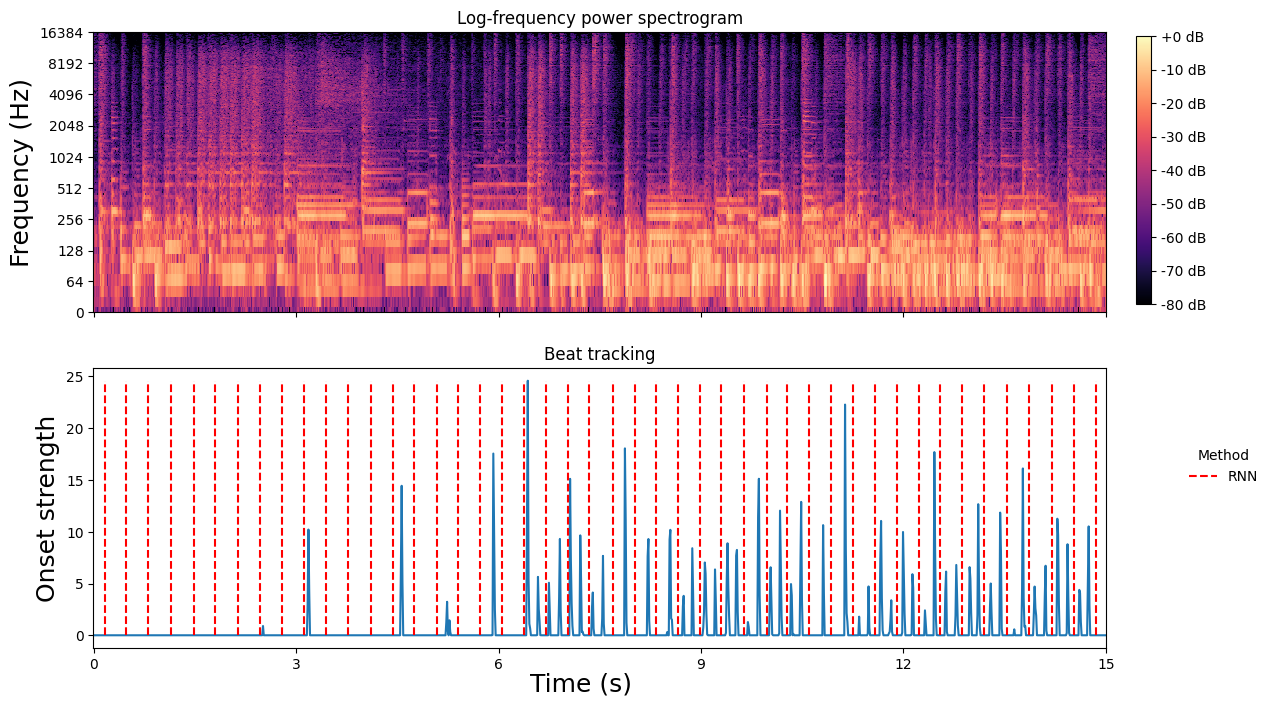

In [4]:
# @title
class OnsetStrengthTrackedBeatsPlot:
  """
  Creates a plot that compares the accuracy of detected beats between two
  methods of pulse estimation - a dynamic programming and predominant local
  pulse estimation algorithm. Also shows a spectrogram of the audio for
  comparison to the osnet strength.
  """
  sample_rate = 44100

  def __init__(self, tracked_beats, **kwargs):
    self.full_mix, _ = librosa.load('youtube.mp3', sr=self.sample_rate, mono=False)
    self.onset_envelope = librosa.onset.onset_strength(
        y=self.full_mix.mean(axis=0),    # We need a mono file here, so average over both channels
        sr=self.sample_rate,
        aggregate=np.median,    # The function used to aggregate overlapping frequencies in one frequency bin   # The maximum frequency to use, corresponding to our upper limit in Spleeter
        center=False    # Do not center the tracked onsets on the envelope: this can cause issues with late annotation, see https://github.com/librosa/librosa/issues/1052
    )
    self.tracked_beats_dp = tracked_beats
    self.x_cutoff = kwargs.get('x_cutoff', 15)
    self.fig, self.ax = plt.subplots(
        nrows=2, ncols=1, figsize=(15, 8), sharex=True, sharey=False
    )

  def _format_x_axis(
      self
  ) -> np.array:
    """
    Returns x-axis times with correct length, according to cutoff
    """

    x = librosa.times_like(
        self.onset_envelope, sr=self.sample_rate, axis=-1,
    )
    return np.array([time for time in x if time < self.x_cutoff])

  def create_plot(
      self
  ) -> None:
    """
    Called from outside the class, generates the plot and saves
    """

    self._create_spectrogram()
    self._create_lineplot()
    self._format_ax()
    self._format_fig()

  def _create_spectrogram(
    self
  ) -> None:
    """
    Creates the spectrogram on the upper axis
    """

    # Get the desired number of samples for the track, with the cutoff
    shape = int((self.sample_rate * self.x_cutoff))
    # Trim the duration of the track and convert to mono
    track = np.resize(self.full_mix, (2, shape)).mean(axis=0)
    # Get the amplitude (in decibels) of the track
    d = librosa.amplitude_to_db(np.abs(librosa.stft(track)), ref=np.max)
    # Show the spectrogram
    spec = librosa.display.specshow(
        d, sr=self.sample_rate,
        x_axis='time', y_axis='log', ax=self.ax[0]
    )
    # Add the colorbar in, on the right of the figure (next to the axis)
    cax = self.fig.add_axes([0.82, 0.54, 0.01, 0.335])
    self.fig.colorbar(spec, cax=cax, orientation='vertical', format="%+2.f dB")

  def _create_lineplot(
      self,
  ) -> None:
    """
    Creates the lineplot (onset envelope and detected beats) on the lower axis
    """

    # Plot our onset envelope, trimmed to the desired length
    x = self._format_x_axis()
    y = self.onset_envelope[:x.shape[0]]
    self.ax[1].plot(x, y)
    # Overlay our tracked beats as vertical lines
    for tb, col, lab in zip(
        [self.tracked_beats_dp,],
        ['red'], ['RNN']
    ):
        # Get only the beats before the cutoff
        lines = np.array([line for line in tb if line < self.x_cutoff])
        # Add the vertical lines onto the plot with the correct color and label
        self.ax[1].vlines(
            lines, ymin=0, ymax=y.max(), color=col, ls='--', label=lab
        )
    # Add the legend in and align with the upper axis colorbar
    self.fig.legend(bbox_to_anchor=(0.91, 0.375), frameon=False, title='Method')

  def _format_ax(
      self
  ) -> None:
    """
    Sets axis characteristics, e.g. title, labels
    """

    # Modify upper axis, the spectrogram
    self.ax[0].set(
        ylim=(0, 16384), xlabel='', title='Log-frequency power spectrogram'
    )
    # Modify lower axis, the line plot
    self.ax[1].set(title='Beat tracking')
    # Apply modifications to both axis
    for ax, lab in zip(self.ax.flatten(), ['Frequency (Hz)', 'Onset strength']):
        ax.set(xticks=np.linspace(0, self.x_cutoff, 6))
        ax.set_ylabel(lab, fontsize=18)

  def _format_fig(
      self
  ) -> None:
    """
    Sets figure-level attributes
    """

    # Adjust plot positioning slightly
    self.fig.subplots_adjust(right=0.8)
    # Add the x-axis label to the bottom of the plot
    self.fig.supxlabel('Time (s)', x=0.45, y=0.05, fontsize=18)

OnsetStrengthTrackedBeatsPlot(tracked_beats=bt.beats).create_plot()

## Evaluate the output

Congratulations, you just used a neural network for the first time! How do the results sound? You can try different combinations of parameters (or different videos) by changing the parameters above and pressing the "Play" button once again.

If you can't think of which tracks to use, you can try the following:

*   Jazz: https://www.youtube.com/watch?v=bCGsXx6WF6I
*   Hip-Hop: https://www.youtube.com/watch?v=h69FSgua80A
*   Psychedelic: https://www.youtube.com/watch?v=oc50wHexbwg
*   Funk: https://www.youtube.com/watch?v=wc7NaHq30p8


## Discussion questions

1.   Do particular styles of music lend themselves better to automatic beat tracking? Which styles work better, and what connects them?
2.   How well does the model handle changes in tempo? What about music with unusual time signatures?
3.   Which parameters seem to have the most impact on the detection? Which parameters have the least impact?
4.   Do settings that work well for one recording work well for another? How much manual tweaking do we need to do?
5.   What are some of the potential applications of this technology, both in research and in practice?



